#### using transfer learning for the segementation job

In [3]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

[]

define the neptune for documenting

In [4]:
# neptune document

import neptune.new as neptune

run = neptune.init(
    project='leeleeroy/UNet-2D-EM',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
    name = "UNet2D_256_resnet",  
)  # necessary credentials, the name could be used to reproduce the results 


https://app.neptune.ai/leeleeroy/UNet-2D-EM/e/UN-25


/home/li52/.local/lib/python3.6/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.local/lib/python3.6/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
# for callbacks in training

from neptune.new.integrations.tensorflow_keras import NeptuneCallback

neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
# neptune document the hyper param.

PARAMS = {'patchify': 256,
          "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
          'epochs':100,
          'batch_size':16}

# log hyper-parameters
run['hyper-parameters'] = PARAMS
run["sys/tags"].add(["model-type: ", "2D_256"])

In [6]:
# !pip install segmentation_models

In [7]:
# data loading 

import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import os
import pandas as pd
import random

In [8]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

# DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
DATA_PATH = './synthetic/'  # in hemera, only use relative path
data_ids = next(os.walk(DATA_PATH))[1]
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|          | 0/3 [00:00<?, ?it/s]/home/li52/.local/lib/python3.6/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


tomo2_focalseries.mrc
tomo3_focalseries.mrc


 67%|██████▋   | 2/3 [00:00<00:00,  5.86it/s]

tomo1_focalseries.mrc
tomo2_groundtruth.mrc


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

tomo3_groundtruth.mrc
tomo1_groundtruth.mrc


In [9]:
# raw data sorting: padding, reshape

import torchio as tio
from patchify import patchify, unpatchify

# training dataset raw
train_raw = np.vstack(([focal[0], focal[1]]));train = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]

trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,512  # padding into the same size
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2]; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];

(512, 256, 256)
(512, 256, 256)


In [10]:
# patchify the images

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1

                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [11]:
# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}
Xtrain_patches, _ = rawPatch(train_padd, patchPara);Xtrain_patches = np.stack((Xtrain_patches,)*3, axis=-1) # dock 3 times, the model expects 3 channel
# print(Xtrain_patches.shape)

Ytrain_patches, _ = rawPatch(label, patchPara);Ytrain_patches = np.expand_dims(Ytrain_patches, -1)
Ytrain_patches = (Ytrain_patches > 0.5).astype(np.float) # binarize the data

# test dataset
Xtest_patches, patchSize = rawPatch(test_padd, patchPara);Xtest_patches = np.stack((Xtest_patches,)*3, axis=-1)
Ytest_patches, _ = rawPatch(Y_test_label, patchPara);Ytest_patches = np.expand_dims(Ytest_patches, -1)
Ytest_patches = (Ytest_patches > 0.5).astype(np.float)
print(Xtest_patches.shape);print(Ytest_patches.shape)

(256, 256, 256, 3)
(256, 256, 256, 1)


In [12]:
# usinng pre-trained weight
import tensorflow
import tensorflow.keras

import segmentation_models as sm

# from keras_applications.resnet import ResNetV2

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [13]:
# !pip install -U scikit-learn scipy matplotlib

In [14]:
# preprocessing the data

# preprocess input
images = Xtrain_patches; masks = Ytrain_patches;
images1=preprocess_input1(images)
print(images1.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(images1, masks, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)


(512, 256, 256, 3)
(384, 256, 256, 3)
(128, 256, 256, 3)


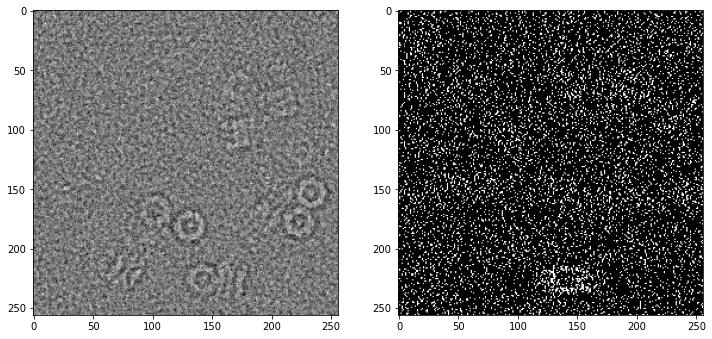

In [15]:
#Sanity check, view few mages

import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(Y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [16]:
# data generator

seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [17]:
# 替代

# image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator.fit(X_train, augment=True, seed=seed)

# image_generator = image_data_generator.flow(X_train, seed=seed)
# valid_img_generator = image_data_generator.flow(X_test, seed=seed)

# mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(Y_train, augment=True, seed=seed)
# mask_generator = mask_data_generator.flow(Y_train, seed=seed)
# valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [18]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [19]:
# generator pack for later use
my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

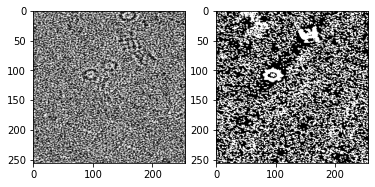

In [20]:
# sanity check
# in the generator size 0-31

for i in range(30,31):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [21]:
# define model

import segmentation_models as sm

# sm.set_framework('tf.keras')  # ！ this serves for the sm.Unet
# sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
# print(model.summary())


In [ ]:
#Fit the model and train

import tensorflow.keras as k

callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    neptune_cbk,
    k.callbacks.TensorBoard(log_dir = 'logsTransfer')
]

history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=2, callbacks = callbacks)

# history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50, callbacks = callbacks)  # change fit into fit generator in hemera

Epoch 1/2


In [ ]:
# training visualization

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# prediction IOU

#IOU
y_pred=model.predict(X_test)  # get test images
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
# sanity check

test = y_pred[127,...]
test2 = y_test[127,...]
print(test.shape)
plt.subplot(1,2,1)
plt.imshow(test,cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(test2,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# visualization

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]  # for test
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]  # GT for the test
prediction = model.predict(test_img_input)  # prediction
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


In [ ]:
# # neptune for showing the test images

for i in range(y_pred.shape[0]):
    image1 = y_pred[i]
    image1 = (image1*255).astype('uint8')  # transfer into uint8
    image2 = y_test[i]  # GT
    run["test/sample_images"].log(neptune.types.File.as_image(image1), name=str(i), descripttion='test images from 3rd stack')  # upload the test results into neptune. could also add 'description'
    run["test/sample_GT"].log(neptune.types.File.as_image(image2), name=str(i), description='groundtruth of test images')

In [ ]:
run.stop()  # remember to stop the neptune